In [3]:
import numpy as onp
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from dipole import VectorValuedKRR
from utils import matern, coulomb

In [4]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'])
y = np.array(data['D'])

In [6]:
from functools import partial

nop = lambda x: x
no_descriptor = partial(matern, descriptor=nop)

In [8]:
sigma_choices = list(onp.linspace(10, 100, 10, dtype=int))
parameters = {'sigma': sigma_choices}

test = slice(20000, 20100)
Xtest, ytest = X[test], y[test]
errors, errors_no_desc = [], []
M = X.shape[0]
size = 50

for _ in range(5):

    indices = onp.random.choice(M, size=size, replace=False)
    Xtrain, ytrain = X[indices], y[indices]

    cross_validation = GridSearchCV(VectorValuedKRR(), parameters)
    cross_validation.fit(Xtrain, ytrain)
    results = cross_validation.cv_results_
    best = np.argmin(results['rank_test_score'])
    best_params = results['params'][best]
    print(f'best params: {best_params}')
    best_model = VectorValuedKRR(**best_params)
    best_model.fit(Xtrain, ytrain)
    best_test_error_matern = -best_model.score(Xtest, ytest).item()
    errors.append(best_test_error_matern)
    print(f'descriptor error: {best_test_error_matern}')

    cross_validation = GridSearchCV(VectorValuedKRR(similarity=no_descriptor), parameters) #, dict(**parameters, similarity=[no]))
    cross_validation.fit(Xtrain, ytrain)
    results = cross_validation.cv_results_
    best = np.argmin(results['rank_test_score'])
    best_params = results['params'][best]
    print(f'best params: {best_params}')
    best_model = VectorValuedKRR(**best_params)
    best_model.fit(Xtrain, ytrain)
    best_test_error_gaussian = -best_model.score(Xtest, ytest).item()
    print(f'no descriptor error: {best_test_error_gaussian}')
    errors_no_desc.append(best_test_error_gaussian)




best params: {'sigma': 10}
descriptor error: 0.16881799697875977
best params: {'sigma': 20}
no descriptor error: 0.16444164514541626
best params: {'sigma': 100}
descriptor error: 0.162628173828125
best params: {'sigma': 20}
no descriptor error: 0.16377870738506317
best params: {'sigma': 10}
descriptor error: 0.1588732749223709
best params: {'sigma': 10}
no descriptor error: 0.1588732749223709
best params: {'sigma': 100}
descriptor error: 0.15167932212352753
best params: {'sigma': 50}
no descriptor error: 0.15212534368038177
best params: {'sigma': 20}
descriptor error: 0.16591697931289673
best params: {'sigma': 20}
no descriptor error: 0.16591697931289673


In [9]:
print(onp.mean(errors))
print(onp.mean(errors_no_desc))

0.16158314943313598
0.16102719008922578


<AxesSubplot:label='69be177e-b6fd-48c2-9555-defdda2cdcce', xlabel='samples trained on', ylabel='gaussian error'>

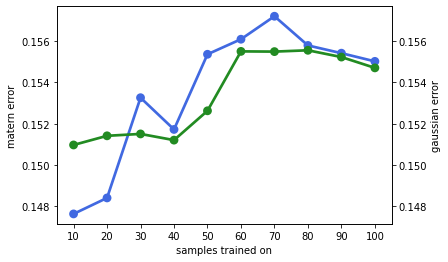

In [41]:
data = pd.DataFrame({'samples trained on': data_subset_sizes, 'matern error': errors_matern, 'gaussian error': errors_gaussian})
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.pointplot(x='samples trained on', y='matern error', data=data, s=100, ax=ax, color='royalblue')
ax2.set_ylim(ax.get_ylim())
sns.pointplot(x='samples trained on', y='gaussian error', data=data, s=100, ax=ax2, color='forestgreen')